Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/CS263_Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS263_Project


Loading all datasets from drive

In [0]:
import pandas as pd
df = pd.read_csv(r"all_data.csv")
test_set = pd.read_csv(r"test_set.csv")
sentiment_data = pd.read_csv(r"sentiment.csv")

In [3]:
!pip install torch
!pip install transformers

Function for BERT Vectorization is defined

In [0]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


def vectorizeBERT(df, bert_type = "bert"):

  if bert_type == "distil":
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
  elif bert_type == "roberta":
    model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')
  else:
    model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

  # Load pretrained model/tokenizer
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  model = model_class.from_pretrained(pretrained_weights)

  tokenized = df["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  # padding step
  max_len = 0
  for i in tokenized.values:
    if len(i) > max_len:
      max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)
  attention_mask.shape

  input_ids = torch.tensor(np.array(padded))
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
  # Slice the output for the first position for all the sequences, take all hidden unit outputs
  features = last_hidden_states[0][:,0,:].numpy()

  return features



Function for obtaining sentiment score using sentiment data is defined

In [0]:
def obtain_sentiment_classifier(sentiment_data,data_select=4000):
  import random
  import pickle
  #Randomly selecting a small portion of sentiment data, since the dataset is too big
  rand_ind = random.sample(range(sentiment_data.shape[0]),data_select)
  sentiment=sentiment_data.iloc[rand_ind]
  # Build the sentiment model
  features = vectorizeBERT(sentiment)
  features_ds = pd.DataFrame(features)
  labels = sentiment["label"]
  train_features, test_features, train_labels, test_labels = train_test_split(features_ds, labels)
  #Logistic Regression classifier for sentiment analysis
  lr_clf_sentiment = LogisticRegression(max_iter=5000)
  lr_clf_sentiment.fit(train_features, train_labels)
  #Calculate score of logistic regression classifier on sentiment data
  sent_accuracy = lr_clf_sentiment.score(test_features, test_labels)
  print("The accuracy of Logistic Regression classifier on sentiment data is: ",sent_accuracy)
  pickle.dump(lr_clf_sentiment, open("sentiment_model", 'wb'))
  return lr_clf_sentiment

In [54]:
# Build the cognitive distortion model
# M x N matrix
import time
start_time = time.time()
features = vectorizeBERT(df)
print("Time taken is:",time.time()-start_time)

Time taken is: 153.5158336162567


Creating training dataset with features and sentiment scores

In [8]:
labels = df["label"]
features_df = pd.DataFrame(features)
lr_clf_sentiment = obtain_sentiment_classifier(sentiment_data,data_select=4000)
sentiment_score = lr_clf_sentiment.predict_log_proba(features)[:,0]
features_df["sentiment_score"] = sentiment_score
features_df.head()

The accuracy of Logistic Regression classifier on sentiment data is:  0.809


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,sentiment_score
0,0.064185,0.116251,0.173751,-0.136374,-0.227259,-0.503813,0.664396,0.809819,-0.078599,-0.401530,-0.008818,-0.270047,-0.016984,0.657804,0.507452,-0.013487,-0.046433,0.574368,0.152785,-0.214532,0.050718,-0.262154,-0.131824,-0.226232,-0.285502,-0.124004,-0.278517,0.019781,0.174474,0.003650,-0.156326,-0.084894,-0.225917,0.195152,0.170384,-0.102753,-0.267985,-0.179697,0.301730,0.115410,...,-0.106473,-0.060724,0.394658,-0.320591,-0.124769,-0.002194,0.049406,-0.493999,-0.146199,-0.163771,0.394479,0.196617,-0.117926,0.008908,0.401485,0.522761,0.008527,-0.097613,0.070396,-0.090552,-0.031218,0.301031,0.295522,-7.521424,-0.152080,-0.155668,-0.248154,-0.139791,-0.608704,0.055255,-0.142869,-0.095100,-0.106877,0.115598,0.115215,-0.001469,-0.145779,0.339752,0.522551,-2.150020
1,0.173912,0.023234,-0.282618,-0.165053,-0.424329,-0.311755,0.568792,0.456151,-0.200455,-0.262142,0.186468,-0.105735,-0.298163,0.657450,0.516508,-0.071780,0.254133,0.539748,0.280533,-0.106023,-0.048515,-0.139862,0.259962,0.153837,-0.333290,-0.192454,-0.161889,0.002372,0.055239,-0.009457,0.122488,0.009130,-0.309751,-0.100182,0.190423,0.069538,-0.310809,-0.221255,-0.004161,0.260224,...,-0.070100,-0.147870,0.492935,-0.420588,0.061425,0.136778,0.015730,-0.258102,-0.140906,-0.376467,0.230319,0.299862,-0.293175,0.233682,0.539116,0.373029,-0.073583,-0.037665,-0.203862,0.212516,0.110676,0.097686,0.256059,-8.026570,-0.096856,-0.250646,-0.278895,0.116706,-0.031764,-0.083000,-0.164207,0.186969,-0.140416,0.250234,-0.172232,-0.073691,0.108512,0.396801,0.679681,-2.680611
2,-0.093854,0.203215,0.143699,-0.192129,-0.288521,-0.283392,0.701010,0.521691,0.172952,-0.497126,-0.021346,-0.291448,-0.195253,0.582004,0.194440,0.269822,-0.013928,0.180351,0.133972,-0.020463,0.115805,-0.235973,0.051620,-0.203749,-0.006068,-0.020587,-0.031401,0.019496,-0.114106,0.145524,-0.197016,0.205308,-0.261083,-0.024287,0.115347,-0.049339,-0.160883,-0.316876,0.413236,-0.063892,...,-0.137487,-0.212946,0.402717,-0.286000,-0.189913,-0.066704,0.174118,-0.569863,0.086228,-0.057636,0.371086,0.260841,-0.072058,-0.066697,0.441553,0.339268,0.038720,-0.086322,0.154244,-0.308330,-0.072550,0.134763,0.397329,-6.701902,-0.170226,0.022921,-0.120816,-0.428781,-0.626987,-0.074123,-0.245851,-0.053830,0.131663,0.203021,0.052046,-0.217257,-0.185266,0.379728,0.519283,-0.956328
3,0.175459,0.332382,-0.073295,-0.187953,-0.489943,-0.281291,0.751253,0.514160,-0.059264,-0.327642,0.007623,-0.074470,-0.115274,0.524753,0.484866,0.238129,0.046454,0.540293,0.261595,0.044107,0.038626,0.018876,0.184113,-0.025048,-0.022937,0.012909,-0.021078,-0.033133,-0.053851,0.241292,0.169756,-0.005172,0.002783,-0.029453,0.278412,-0.153979,-0.218413,-0.244795,0.249539,-0.057608,...,-0.052503,-0.200642,0.589456,-0.847173,-0.134977,0.219423,0.020818,-0.552905,-0.038738,-0.090613,0.147529,0.388691,-0.169955,0.010452,0.318906,0.495270,-0.077713,-0.147221,0.037615,-0.026333,0.153772,0.050382,0.275281,-7.260122,-0.039380,-0.160293,-0.094471,-0.259358,-0.111941,-0.309998,-0.013568,0.001463,-0.120220,0.554974,0.009258,0.009079,0.057054,0.363188,0.728043,-2.341075
4,0.109969,0.171826,0.260536,0.087237,-0.108688,-0.360521,0.648624,0.754591,-0.139784,-0.434686,0.072301,-0.015631,-0.328584,0.252345,0.580037,0.265758,-0.218179,0.467285,0.047808,0.172819,0.016759,-0.538792,0.246859,-0.066110,0.033810,-0.130635,-0.019634,-0.243074,0.135270,0.099332,-0.328880,0.062511,-0.151040,0.017045,0.155072,-0.275657,-0.219200,-0.192958,0.489210,0.298175,...,-0.114253,-0.005308,0.524833,-0.103920,0.177931,-0.057709,0.053240,-0.417177,0.032487,0.096229,-0.002384,0.317829,0.116646,-0.119399,0.429504,0.421311,0.233301,-0.075609,0.242171,-0.245735,-0.133638,0.101578,0.153715,-6.844507,-0.030501,-0.194800,-0.2

Evaluating  Logistic Regression Classifier on the features obtained

In [21]:
train_features, test_features, train_labels, test_labels = train_test_split(features_df, labels)

lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
score = lr_clf.score(test_features, test_labels)
print("Accuracy without scaling is: ",score)
from sklearn import preprocessing
# Scale
scaled_train_features = preprocessing.scale(train_features)
scaled_test_features = preprocessing.scale(test_features)

lr_clf_scaled = LogisticRegression(max_iter=5000)
lr_clf_scaled.fit(scaled_train_features, train_labels)
score = lr_clf_scaled.score(scaled_test_features, test_labels)
print("Accuracy with scaling is: ",score)


Accuracy without scaling is:  0.869198312236287
Accuracy with scaling is:  0.8734177215189873


As we can see from above scaling the features barely affects the accuracy and hence we drop scaling moving forward

Evaluating Logistic Regression Classifier on a Random Test Set not a part of the augmented dataset used for training.

In [40]:
def unbiased_test_score(test_set,lr_clf_sentiment,model=lr_clf,return_mode=False):
  test = vectorizeBERT(test_set)
  test_l = test_set["label"]
  test_score = lr_clf_sentiment.predict_log_proba(test)[:,0]
  test_df = pd.DataFrame(test)
  test_df["sentiment_score"] = test_score
  print("Score for Random unbiased Dataset",model.score(test_df, test_l))
  if return_mode:
    return model.predict(test_df),model.predict_proba(test_df)[:,0],test_l

unbiased_test_score(test_set,lr_clf_sentiment,lr_clf)


Score for Random unbiased Dataset 0.82


Evaluating Linear SVM on a Random Test Set not a part of the augmented dataset used for training.

In [31]:
from sklearn.svm import SVC
our_svm_model = SVC(kernel = "linear",C=1000,random_state=1)
our_svm_model.fit(train_features, train_labels)
biased_Score = our_svm_model.score(test_features, test_labels)
print("Biased score for SVM is: ",biased_Score)
unbiased_test_score(test_set,lr_clf_sentiment,our_svm_model)

Biased score for SVM is:  0.8860759493670886
Score for Random unbiased Dataset 0.78


Evaluating RandomForestClassifier on a Random Test Set not a part of the augmented dataset used for training.

In [53]:
from sklearn.ensemble import RandomForestClassifier
modelRFC = RandomForestClassifier()
modelRFC.fit(train_features, train_labels)
biased_Score = modelRFC.score(test_features, test_labels)
print("Biased score for RandomForestClassifier is: ",biased_Score)
unbiased_test_score(test_set,lr_clf_sentiment,modelRFC)


Biased score for RandomForestClassifier is:  0.8734177215189873
Score for Random unbiased Dataset 0.72


Evaluating XGBoostClassifier on a Random Test Set not a part of the augmented dataset used for training.

In [32]:
from xgboost import XGBClassifier
modelXGB = XGBClassifier()
modelXGB.fit(train_features, train_labels)
biased_Score = modelXGB.score(test_features, test_labels)
print("Biased score for XGBoostClassifier is: ",biased_Score)
unbiased_test_score(test_set,lr_clf_sentiment,modelXGB)

Biased score for XGBoostClassifier is:  0.8860759493670886
Score for Random unbiased Dataset 0.72


In [0]:
pd.DataFrame(best_clf.cv_results_).to_csv("results.csv")

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression(max_iter=5000)],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear','lbfgs']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))},
    {'classifier' : [SVC(probability=True)],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__kernel' : ['linear','rbf']},
    {'classifier' : [XGBClassifier()]}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


best_clf = clf.fit(train_features, train_labels)


print('Best parameters are: ',best_clf.best_params_)
print('Best score is: ',best_clf.best_score_)

pd.DataFrame(best_clf.cv_results_)

Fitting 5 folds for each of 181 candidates, totalling 905 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 905 out of 905 | elapsed:  4.0min finished


Best parameters are:  {'classifier': SVC(C=29.763514416313132, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False), 'classifier__C': 29.763514416313132, 'classifier__kernel': 'rbf'}
Best score is:  0.902974490298434


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_classifier__max_features,param_classifier__n_estimators,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.036363,0.013969,0.003116,0.000351,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l1,liblinear,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.482517,0.485915,0.478873,0.478873,0.478873,0.481011,0.002830,157
1,0.003037,0.000170,0.000000,0.000000,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l1,lbfgs,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,163
2,0.030196,0.002936,0.003063,0.000191,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l2,liblinear,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.573427,0.598592,0.612676,0.577465,0.605634,0.593559,0.015498,145
3,0.028028,0.005011,0.003029,0.000351,"LogisticRegression(C=1.0, class_weight=None, d...",0.0001,l2,lbfgs,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.559441,0.549296,0.591549,0.577465,0.570423,0.569635,0.014559,146
4,0.023030,0.002262,0.004031,0.002235,"LogisticRegression(C=1.0, class_weight=None, d...",0.000263665,l1,liblinear,NaN,NaN,NaN,"{'classifier': LogisticRegression(C=1.0, class...",0.482517,0.485915,0.478873,0.478873,0.478873,0.481011,0.002830,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.842693,0.027362,0.038479,0.003932,"SVC(C=29.763514416313132, break_ties=False, ca...",3792.69,NaN,NaN,NaN,NaN,linear,"{'classifier': SVC(C=29.763514416313132, break...",0.895105,0.922535,0.880282,0.852113,0.873239,0.884655,0.023463,31
177,1.147630,0.102101,0.046747,0.004232,"SVC(C=29.763514416313132, break_ties=False, ca...",3792.69,NaN,NaN,NaN,NaN,rbf,"{'classifier': SVC(C=29.763514416313132, break...",0.895105,0.950704,0.908451,0.873239,0.873239,0.900148,0.028630,2
178,0.841886,0.029781,0.035627,0.001746,"SVC(C=29.763514416313132, break_ties=False, ca...",10000,NaN,NaN,NaN,NaN,linear,"{'classifier': SVC(C=29.763514416313132, break...",0.895105,0.922535,0.880282,0.852113,0.873239,0.884655,0.023463,31
179,1.171069,0.099468,0.044243,0.001370,"SVC(C=29.763514416313132, break_ties=False, ca...",10000,NaN,NaN,NaN,NaN,rbf,"{'classifier': SVC(C=29.763514416313132, break...",0.895105,0.950704,0.908451,0.873239,0.873239,0.900148,0.028630,2


In [0]:
import pickle
pickle.dump(best_clf, open("best_clf_bert", 'wb'))


In [39]:
unbiased_test_score(test_set,lr_clf_sentiment,best_clf)

Score for Random unbiased Dataset 0.88


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


def evaluation_parameters(y_test,y_pred):
  con_mat = confusion_matrix(y_test,y_pred)
  tn, fp, fn, tp = con_mat.ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*precision*recall/(precision+recall)
  acc = (tp+tn)/(tn+fn+fp+tp)
  print("Confusion Matrix:")
  print(con_mat)
  print("The precision is: ",precision)
  print("The recall is: ",recall)
  print("The f1_score is: ",f1)
  print("The accuracy is: ",acc)

def plot_roc(y_test,y_score):
  fpr,tpr,thresh=roc_curve(y_test,y_score)
  plt.plot(fpr,tpr)
  plt.grid()
  plt.ylim(0,1.1)
  print("The roc score is ",roc_auc_score(y_test,y_score))
  plt.xlabel("Specificity")
  plt.ylabel("Sensitivity")
  plt.title("ROC Curve")

In [41]:
y_pred,y_score,y_test = unbiased_test_score(test_set,lr_clf_sentiment,best_clf,True)

Score for Random unbiased Dataset 0.88


In [43]:
evaluation_parameters(y_test,y_pred)

Confusion Matrix:
[[20  4]
 [ 2 24]]
The precision is:  0.8571428571428571
The recall is:  0.9230769230769231
The f1_score is:  0.888888888888889
The accuracy is:  0.88


The roc score is  0.11538461538461539


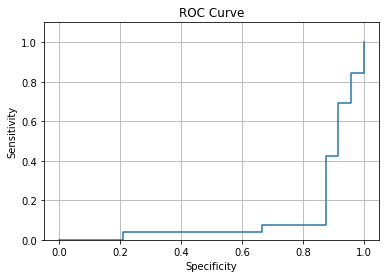

In [46]:
plot_roc(y_test,y_score)